# Automatic classification of eclipsing binary stars using deep learning methods

> Vstupne datasety (overcontact_0_random_50000.pkl, overcontact_1_random_50000.pkl) boli vytvorene pomocou binaries_detached_random.ipynb a binaries_overcontact_random.ipynb

Experiment 1:

- datasety: detached_random(50 000)
              overcontact_random(50 000) 
- vstup do modelu: concat 5 kriviek (BRUVI)
- šum: stochastic_noise_generator
- train_test_split: test_size=0.2
- výstup modelu: klasifikacia 0 -> detached, 
                            1 -> overcontact
- evaluácia: concat 5 kriviek test (BRUVI), nad 0.5 -> 1
- checkpoint: monitor: val_acc, mode: max


Experiment 2:
 
- datasety: detached_random(50 000)
              overcontact_random(50 000) 
- vstup do modelu: 1 typ kriviek (U) 
- šum: stochastic_noise_generator
- train_test_split: test_size=0.2
- výstup modelu: klasifikacia 0 -> detached, 
                            1 -> overcontact
- evaluácia: po jednom krivky (BRUVI), nad 0.5 -> 1
- checkpoint: monitor: val_acc, mode: max


Experiment 3:

- datasety: detached_random(50 000)
              overcontact_random(50 000) 
- vstup do modelu: krivky (BRUVI) spojene do jedneho datasetu
- šum: stochastic_noise_generator
- train_test_split: test_size=0.2
- výstup modelu: klasifikacia 0 -> detached, 
                            1 -> overcontact
- evaluácia: krivky (BRUVI) spojene do jedneho datasetu, nad 0.5 -> 1
- checkpoint: monitor: val_acc, mode: max




In [1]:
import numpy as np
import pandas as pd
import json
import pickle
np.random.seed(1234)

from noise_generator import stochastic_noise_generator
from sklearn.model_selection import train_test_split

from keras.utils.vis_utils import plot_model

from keras.utils import np_utils
from keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split

from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D, SpatialDropout1D, GlobalAveragePooling1D
from keras.layers import Input, Dense, concatenate, Activation, LSTM, Bidirectional, Flatten, Dropout
from keras.models import Model
from keras.models import Sequential
from keras.layers.merge import Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

import imblearn
from imblearn import under_sampling, over_sampling
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

import scikitplot as skplt

In [5]:
# V pripade ak boli chyby s importami, tak je potrebne to spustit (robi sa so zdielanymi prostrediami)

# %pip install keras
# %pip install elisa
# %pip install imblearn
# %pip install --upgrade tensorflow
# %pip install --upgrade tensorflow-gpu
# %pip install scikit-plot

Note: you may need to restart the kernel to use updated packages.


## Data load

- load synthetic light curve - ELISa
- Loads previously prepared data,

In [2]:
data_overcontact_0 = pd.read_pickle("overcontact_0_random_50000.pkl")
data_overcontact_0.head(1)

,id,Bessell_U,Bessell_B,Bessell_V,Bessell_R,Bessell_I,overcontact
0,12160125,"[0.9095548429271283, 0.9096082039388556, 0.909...","[0.9237054157099205, 0.9237634792973173, 0.923...","[0.9534677612386128, 0.9535537166389574, 0.953...","[0.9640869673287129, 0.9641875711518034, 0.964...","[0.9742861631948141, 0.9744010066616171, 0.974...",0


In [3]:
data_overcontact_1 = pd.read_pickle("overcontact_1_random_50000.pkl")
data_overcontact_1.head(1)

,id,Bessell_U,Bessell_B,Bessell_V,Bessell_R,Bessell_I,overcontact
0,40999466,"[0.5651117951032836, 0.5654216264752362, 0.566...","[0.5776138752169334, 0.5779204169126406, 0.578...","[0.6019426084736251, 0.6022399009379724, 0.603...","[0.6139324860808401, 0.6142244857058357, 0.615...","[0.6273054509486395, 0.6275911143294645, 0.628...",1


In [4]:
data = pd.concat([data_overcontact_0, data_overcontact_1])
data.head(1)

,id,Bessell_U,Bessell_B,Bessell_V,Bessell_R,Bessell_I,overcontact
0,12160125,"[0.9095548429271283, 0.9096082039388556, 0.909...","[0.9237054157099205, 0.9237634792973173, 0.923...","[0.9534677612386128, 0.9535537166389574, 0.953...","[0.9640869673287129, 0.9641875711518034, 0.964...","[0.9742861631948141, 0.9744010066616171, 0.974...",0


### Check data 

In [5]:
data.dtypes

id              int64
Bessell_U      object
Bessell_B      object
Bessell_V      object
Bessell_R      object
Bessell_I      object
overcontact     int64
dtype: object

In [6]:
data['overcontact'].value_counts()

1    50000
0    50000
Name: overcontact, dtype: int64

## Data preparation
- train_test_split
- bessel_to_array -> comma seperated string transforms to array
- add noice to train and test sets
> musi to byt v tomto poradi lebo ked sa aplikuje noice tak uz nejde urobit train_test_split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(data, data['overcontact'], test_size=0.2, random_state=42)

# Check shapes after split
print(X_train.shape)
print("########")
print(y_train)
print("########")
print(X_test.shape)
print("########")
print(y_test)
print("########")

(80000, 7)
########
25220    1
48955    0
44966    0
13568    0
42727    1
        ..
6265     0
4886     1
26820    1
860      0
15795    0
Name: overcontact, Length: 80000, dtype: int64
########
(20000, 7)
########
25721    1
30184    1
19864    0
26699    1
42991    1
        ..
32595    0
29313    0
37862    0
3421     1
42410    0
Name: overcontact, Length: 20000, dtype: int64
########


In [8]:
def bessel_to_array(column_name, df):
    """Model expects array input. 
    This function transforms all curves in 1 column (400 comma seperated numbers) to array"""
    newData_bessell = []
    for row in df[column_name]:
        newRow = []
        for valueIndex in range(len(row)):
            newRow.append([row[valueIndex]])
        newData_bessell.append(newRow) 
    newData_bessell = np.array(newData_bessell)
    return newData_bessell

In [9]:
X_train_with_arrays_noise = []
for column in ['Bessell_U','Bessell_B','Bessell_V','Bessell_R','Bessell_I']:
    X_train_with_arrays_noise.append(stochastic_noise_generator(bessel_to_array(column, X_train)))
    print(column + " " + "prossessed")

Bessell_U prossessed
Bessell_B prossessed
Bessell_V prossessed
Bessell_R prossessed
Bessell_I prossessed


In [10]:
X_test_with_arrays_noise = []
for column in ['Bessell_U','Bessell_B','Bessell_V','Bessell_R','Bessell_I']:
    X_test_with_arrays_noise.append(stochastic_noise_generator(bessel_to_array(column, X_test)))
    print(column + " " + "prossessed")

Bessell_U prossessed
Bessell_B prossessed
Bessell_V prossessed
Bessell_R prossessed
Bessell_I prossessed


In [11]:
# (5, 2, 16000, 400, 1) -> meaning: 
# 5 - UBVRI
# 2 - normalized light curve with added noise, standard deviation of observations
# 16000 - number of curves
# 400 - size of 1 curve
# 1 - detached or overcontact

print(np.array(X_train_with_arrays_noise).shape)
print(np.array(X_test_with_arrays_noise).shape)

(5, 2, 80000, 400, 1)
(5, 2, 20000, 400, 1)


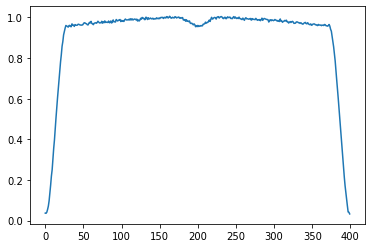

In [12]:
# Check if noice was added successfully
plt.plot(X_train_with_arrays_noise[1][0][1500])

In [13]:
# Check if U,B,V,R,I version of the same curve with noice is different
print(np.array_equal(X_train_with_arrays_noise[0][0], X_train_with_arrays_noise[1][0]))
print(np.array_equal(X_train_with_arrays_noise[1][0], X_train_with_arrays_noise[2][0]))
print(np.array_equal(X_train_with_arrays_noise[2][0], X_train_with_arrays_noise[3][0]))
print(np.array_equal(X_train_with_arrays_noise[3][0], X_train_with_arrays_noise[4][0]))

False
False
False
False


In [14]:
# target is overcontact
target = np.array(y_train)
print(target)

# just to be sure that both types are in dataset
exists = 0 in target
print(exists)
exists = 1 in target
print(exists)

[1 0 0 ... 1 0 0]
True
True


> Control the shape and check if the dataset is imbalanced (ale nacital som si z oboch 10 000 cize viem ze by mal byt vyvazeny)

In [15]:
print(target.shape)

print(X_train_with_arrays_noise[0][0].shape)
print(X_train_with_arrays_noise[1][0].shape)
print(X_train_with_arrays_noise[2][0].shape)
print(X_train_with_arrays_noise[3][0].shape)
print(X_train_with_arrays_noise[4][0].shape)

print(Counter(target))

(80000,)
(80000, 400, 1)
(80000, 400, 1)
(80000, 400, 1)
(80000, 400, 1)
(80000, 400, 1)
Counter({1: 40035, 0: 39965})


    - fit and apply the transform

In [16]:
def print_shape_counter(column, target):
    print(column.shape)
    print(target.shape)
    print(Counter(target))

In [17]:
for i in range(5):
    print_shape_counter(X_train_with_arrays_noise[i][0], y_train)
    print("")

(80000, 400, 1)
(80000,)
Counter({1: 40035, 0: 39965})

(80000, 400, 1)
(80000,)
Counter({1: 40035, 0: 39965})

(80000, 400, 1)
(80000,)
Counter({1: 40035, 0: 39965})

(80000, 400, 1)
(80000,)
Counter({1: 40035, 0: 39965})

(80000, 400, 1)
(80000,)
Counter({1: 40035, 0: 39965})



In [18]:
# transform to categorical
y_train = np_utils.to_categorical(y_train, 2)
y_train

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [19]:
#Check shape 
print(np.array(X_train_with_arrays_noise).shape)
print(y_train.shape)
print((y_train))

(5, 2, 80000, 400, 1)
(80000, 2)
[[0. 1.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [1. 0.]
 [1. 0.]]


# Multiple models
> always choose only one

## experiment 1 -> biLSTM + CNN

In [2]:
inputU = Input(shape=(400,1))
inputB = Input(shape=(400,1))
inputV = Input(shape=(400,1))
inputR = Input(shape=(400,1))
inputI = Input(shape=(400,1))

u = Bidirectional(LSTM(64, return_sequences=True,dropout=0.1,recurrent_dropout=0.1))(inputU)
u = Flatten()(u)
u = Model(inputs=inputU, outputs=u)
u1 = Conv1D(32, kernel_size = 3, padding = "valid", input_shape=(400,1))(inputU)
u1 = MaxPooling1D(2)(u1)
u1 = Conv1D(32, kernel_size = 3, padding = "valid")(u1)
u1 = MaxPooling1D(2)(u1)
u1 = Flatten()(u1)
u1 = Model(inputs=inputU, outputs=u1)

b = Conv1D(32, kernel_size = 3, padding = "valid", input_shape=(400,1))(inputB)
b = MaxPooling1D(2)(b)
b = Conv1D(32, kernel_size = 3, padding = "valid")(b)
b = MaxPooling1D(2)(b)
b = Flatten()(b)
b = Model(inputs=inputB, outputs=b)

v = Bidirectional(LSTM(64, return_sequences=True,dropout=0.1,recurrent_dropout=0.1))(inputV)
v = Flatten()(v)
v = Model(inputs=inputV, outputs=v)

r = Bidirectional(LSTM(64, return_sequences=True,dropout=0.1,recurrent_dropout=0.1))(inputR)
r = Flatten()(r)
r = Model(inputs=inputR, outputs=r)

i = Bidirectional(LSTM(64, return_sequences=True,dropout=0.1,recurrent_dropout=0.1))(inputI)
i = Flatten()(i)
i = Model(inputs=inputI, outputs=i)

x = concatenate([u.output, u1.output, b.output,v.output,r.output,i.output])
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
output = Dense(2, activation='softmax')(x)

classifier = Model(inputs=[u.input, b.input, v.input, r.input, i.input ], outputs=output)
classifier.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
print(classifier.summary())

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 400, 1)]     0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 400, 1)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 398, 32)      128         ['input_1[0][0]']                
                                                                                                  
 conv1d_2 (Conv1D)              (None, 398, 32)      128         ['input_2[0][0]']                
                                                                                            

In [4]:
plot_model(classifier, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [23]:
# checkpoint: save only best model

saved_model = "model_experiment_1_50000.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=3)
callbacks_list = [checkpoint, early]

### Training  
UBVRI version of the same curve as input

In [24]:
history = classifier.fit([X_train_with_arrays_noise[0][0], X_train_with_arrays_noise[1][0], X_train_with_arrays_noise[2][0], X_train_with_arrays_noise[3][0], X_train_with_arrays_noise[4][0]], y_train, 
                         validation_split=0.1, epochs=3, batch_size=128, verbose=1, callbacks = callbacks_list)

Epoch 1/3
563/563 [==============================] - ETA: 0s - loss: 0.1426 - acc: 0.9614
Epoch 00001: val_acc improved from -inf to 0.97787, saving model to model_experiment_1_50000.hdf5
563/563 [==============================] - 1797s 3s/step - loss: 0.1426 - acc: 0.9614 - val_loss: 0.0521 - val_acc: 0.9779
Epoch 2/3
563/563 [==============================] - ETA: 0s - loss: 0.0477 - acc: 0.9827
Epoch 00002: val_acc improved from 0.97787 to 0.98750, saving model to model_experiment_1_50000.hdf5
563/563 [==============================] - 1733s 3s/step - loss: 0.0477 - acc: 0.9827 - val_loss: 0.0331 - val_acc: 0.9875
Epoch 3/3
563/563 [==============================] - ETA: 0s - loss: 0.0397 - acc: 0.9852
Epoch 00003: val_acc improved from 0.98750 to 0.99025, saving model to model_experiment_1_50000.hdf5
563/563 [==============================] - 1720s 3s/step - loss: 0.0397 - acc: 0.9852 - val_loss: 0.0276 - val_acc: 0.9902


## experiment 2 -> biLSTM + CNN

In [23]:
inputs = Input(shape=(400,1))

a = Bidirectional(LSTM(64, return_sequences=True,dropout=0.1,recurrent_dropout=0.1))(inputs)
a = Flatten()(a)

b = Conv1D(32, kernel_size = 3, padding = "valid", input_shape=(400,1))(inputs)
b = MaxPooling1D(2)(b)
b = Conv1D(32, kernel_size = 3, padding = "valid")(b)
b = MaxPooling1D(2)(b)
b = Flatten()(b)

x = concatenate([a,b])
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)

output = Dense(2, activation='softmax')(x)
classifier = Model(inputs=inputs, outputs=output)
classifier.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
print(classifier.summary())

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 400, 1)]     0           []                               
                                                                                                  
 conv1d_4 (Conv1D)              (None, 398, 32)      128         ['input_6[0][0]']                
                                                                                                  
 max_pooling1d_4 (MaxPooling1D)  (None, 199, 32)     0           ['conv1d_4[0][0]']               
                                                                                                  
 conv1d_5 (Conv1D)              (None, 197, 32)      3104        ['max_pooling1d_4[0][0]']        
                                                                                            

In [24]:
saved_model = "model_experiment_2_50000.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=3)
callbacks_list = [checkpoint, early]

In [25]:
history = classifier.fit(X_train_with_arrays_noise[0][0], y_train, validation_split=0.2, epochs=5, batch_size=128, verbose=1, callbacks = callbacks_list)

Epoch 1/5
500/500 [==============================] - ETA: 0s - loss: 0.1113 - acc: 0.9584
Epoch 00001: val_acc improved from -inf to 0.98175, saving model to model_experiment_2_50000.hdf5
500/500 [==============================] - 163s 320ms/step - loss: 0.1113 - acc: 0.9584 - val_loss: 0.0513 - val_acc: 0.9818
Epoch 2/5
500/500 [==============================] - ETA: 0s - loss: 0.0546 - acc: 0.9798
Epoch 00002: val_acc improved from 0.98175 to 0.98750, saving model to model_experiment_2_50000.hdf5
500/500 [==============================] - 159s 318ms/step - loss: 0.0546 - acc: 0.9798 - val_loss: 0.0340 - val_acc: 0.9875
Epoch 3/5
500/500 [==============================] - ETA: 0s - loss: 0.0435 - acc: 0.9836
Epoch 00003: val_acc did not improve from 0.98750
500/500 [==============================] - 160s 320ms/step - loss: 0.0435 - acc: 0.9836 - val_loss: 0.0423 - val_acc: 0.9849
Epoch 4/5
500/500 [==============================] - ETA: 0s - loss: 0.0399 - acc: 0.9855
Epoch 00004: val

## experiment 3 -> same model as experiment 2

In [30]:
saved_model = "model_experiment_3_50000.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=3)
callbacks_list = [checkpoint, early]

In [31]:
x_train = np.concatenate((X_train_with_arrays_noise[0][0],
                          X_train_with_arrays_noise[1][0], 
                          X_train_with_arrays_noise[2][0], 
                          X_train_with_arrays_noise[3][0],
                          X_train_with_arrays_noise[4][0])) 

In [32]:
y_train_mixed = np.concatenate((y_train,
                                y_train, 
                                y_train, 
                                y_train,
                                y_train)) 

In [33]:
history = classifier.fit(x_train, y_train_mixed, validation_split=0.2, epochs=5, batch_size=128, verbose=1, callbacks = callbacks_list)

Epoch 1/5
2500/2500 [==============================] - ETA: 0s - loss: 0.0315 - acc: 0.9882
Epoch 00001: val_acc improved from -inf to 0.99080, saving model to model_experiment_3_50000.hdf5
2500/2500 [==============================] - 792s 317ms/step - loss: 0.0315 - acc: 0.9882 - val_loss: 0.0249 - val_acc: 0.9908
Epoch 2/5
2500/2500 [==============================] - ETA: 0s - loss: 0.0239 - acc: 0.9913
Epoch 00002: val_acc did not improve from 0.99080
2500/2500 [==============================] - 798s 319ms/step - loss: 0.0239 - acc: 0.9913 - val_loss: 0.0303 - val_acc: 0.9886
Epoch 3/5
2500/2500 [==============================] - ETA: 0s - loss: 0.0189 - acc: 0.9935
Epoch 00003: val_acc improved from 0.99080 to 0.99227, saving model to model_experiment_3_50000.hdf5
2500/2500 [==============================] - 794s 317ms/step - loss: 0.0189 - acc: 0.9935 - val_loss: 0.0206 - val_acc: 0.9923
Epoch 4/5
2500/2500 [==============================] - ETA: 0s - loss: 0.0164 - acc: 0.9942
Ep

In [23]:
# Define function for plot loss and accuracy during training
def trainingLoss(history):
    plt.style.use('ggplot')
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.savefig('tarin1.png', bbox_inches='tight')
    plt.show()
    plt.style.use('ggplot')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.savefig('tarin2.png', )
    plt.show()

Plot training graphs

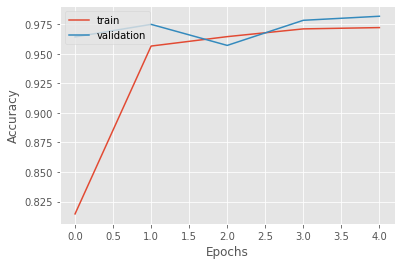

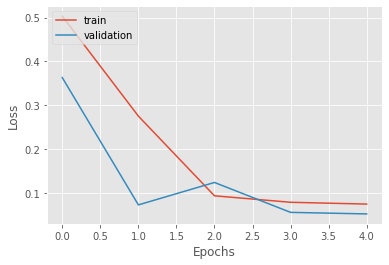

In [24]:
trainingLoss(history)

# Model experiment 1 evaluation

In [24]:
def evaluate_all(model_path, input_data, y_test):
    classifier = load_model(model_path)
    # y_pred returns probability of detached and overcontact 
    # for example [1.4059671e-04, 9.9985933e-01], 
    # means detached with prob. 0.0001405  and overcontact with prob 0.998
    y_pred = classifier.predict(input_data)
    # print(y_pred)
    
    # for example [1.4059671e-04, 9.9985933e-01] -> [0, 1], it is marked as detached 
    y_pred2 = np.where(y_pred > 0.5, 1, 0)
    
    # test data [0,1,...] is converted to categorical [[0,1],[1,0]]
    target_test = np.array(y_test)
    target_test = np_utils.to_categorical(target_test, 2)
    
    # confusion matrix -old 
    # cm = confusion_matrix(target_test.argmax(axis=1), y_pred2.argmax(axis=1))
    # print("Confusion matrix: \n" + str(cm))
    
    # confusion matrix - nice print 
    matrix=skplt.metrics.plot_confusion_matrix(target_test.argmax(axis=1), y_pred2.argmax(axis=1))
    matrix.xaxis.set_ticklabels(['detached', 'overcontact'])
    matrix.yaxis.set_ticklabels(['detached', 'overcontact'])
    matrix
    
    target_names= ['detached', 'overcontact']
    print("Classification report: \n" + classification_report(target_test.argmax(axis=1), y_pred2.argmax(axis=1),target_names=target_names))

    # from categorical [0, 1] -> 1
    y_true = target_test.argmax(axis=1)
    
    skplt.metrics.plot_roc(y_true, y_pred)
    plt.savefig('roc_auc.png')
    plt.show()
    
    input_data = np.array(input_data)
    
    
    limit_plot=0
    for j in range(len(y_pred2)): 
        if (y_pred2[j].argmax(axis=0) == 1) and (target_test[j].argmax(axis=0) == 0):
            if input_data.ndim == 4:
                plt.plot(input_data[0][j],label = str(y_test.iloc[[j]].index[0]) + ", " +str(y_test.iloc[[j]].values[0]))
                fig1 = plt.figure(1)
                fig1.text(0.45, 0.9, "detached 0", ha="center", va="bottom", color="green")
                fig1.text(0.53, 0.9, "/", ha="center", va="bottom",  color="black")
                fig1.text(0.62, 0.9, "overcontact 1", ha="center", va="bottom",  color="red")
                limit_plot=limit_plot+1
            else:
                plt.plot(input_data[j],label = str(y_test.iloc[[j]].index[0]) + ", " +str(y_test.iloc[[j]].values[0]))
                fig1 = plt.figure(1)
                fig1.text(0.45, 0.9, "detached 0", ha="center", va="bottom" ,color="green")
                fig1.text(0.53, 0.9, "/", ha="center", va="bottom",  color="black")
                fig1.text(0.62,0.9, "overcontact 1", ha="center", va="bottom",  color="red")
                limit_plot=limit_plot+1
            if limit_plot == 2:
                break 

    
    plt.legend(loc='upper right')       
    plt.savefig('image.png')
    plt.show()     


    limit_plot2=0
    for j in range(len(y_pred2)): 
        if (y_pred2[j].argmax(axis=0) == 0) and (target_test[j].argmax(axis=0) == 1):
            if input_data.ndim == 4:
                plt.plot(input_data[0][j],label = str(y_test.iloc[[j]].index[0]) + ", " +str(y_test.iloc[[j]].values[0]))
                fig1 = plt.figure(1)
                fig1.text(0.45, 0.9, "detached 0", ha="center", va="bottom", color="red")
                fig1.text(0.53, 0.9, "/", ha="center", va="bottom",  color="black")
                fig1.text(0.62, 0.9, "overcontact 1", ha="center", va="bottom",  color="green")
                limit_plot2=limit_plot2+1
                
            else:
                plt.plot(input_data[j],label = str(y_test.iloc[[j]].index[0]) + ", " +str(y_test.iloc[[j]].values[0]))
                fig1 = plt.figure(1)
                fig1.text(0.45, 0.9, "detached 0", ha="center", va="bottom", color="red")
                fig1.text(0.53, 0.9, "/", ha="center", va="bottom",  color="black")
                fig1.text(0.62, 0.9, "overcontact 1", ha="center", va="bottom",  color="green")
                limit_plot2=limit_plot2+1
            if limit_plot2 == 2:
                break 
    
    plt.legend(loc='upper right')       
    plt.savefig('image2.png')
    plt.show()

(20000,)
Classification report: 
              precision    recall  f1-score   support

    detached       0.99      0.98      0.99     10035
 overcontact       0.98      0.99      0.99      9965

    accuracy                           0.99     20000
   macro avg       0.99      0.99      0.99     20000
weighted avg       0.99      0.99      0.99     20000



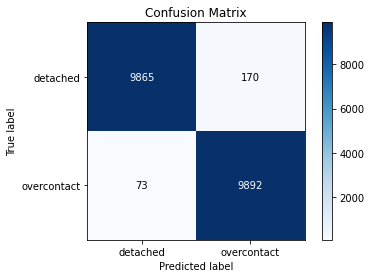

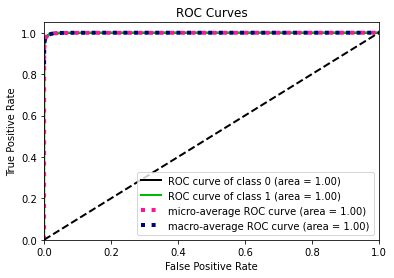

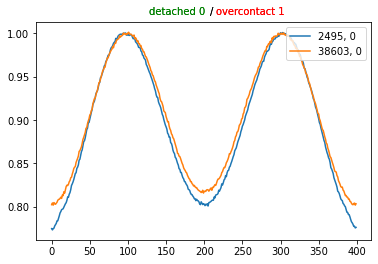

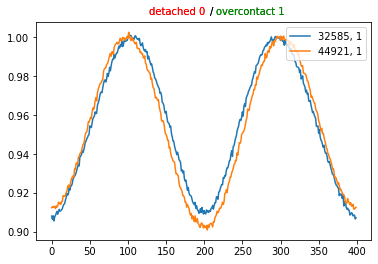

In [25]:
processed_test_data=[
 X_test_with_arrays_noise[0][0],
 X_test_with_arrays_noise[1][0],
 X_test_with_arrays_noise[2][0],
 X_test_with_arrays_noise[3][0],
 X_test_with_arrays_noise[4][0]]

print(y_test.shape)

evaluate_all('model_experiment_1_50000.hdf5', processed_test_data, y_test)

# Model 2 evaluation

(20000,)
(5, 20000, 400, 1)
Classification report: 
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     10035
           1       0.99      0.99      0.99      9965

    accuracy                           0.99     20000
   macro avg       0.99      0.99      0.99     20000
weighted avg       0.99      0.99      0.99     20000



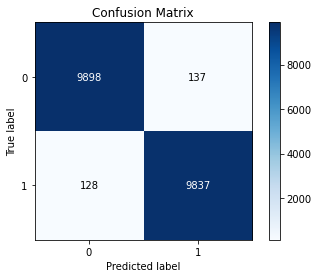

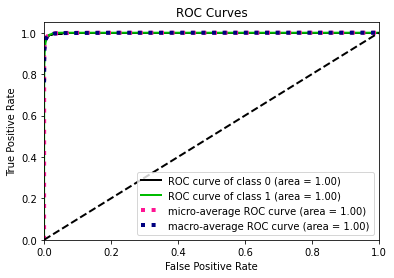

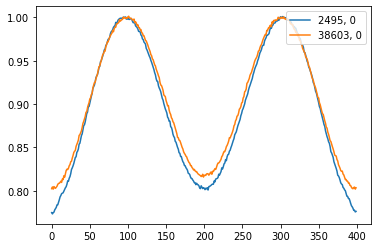

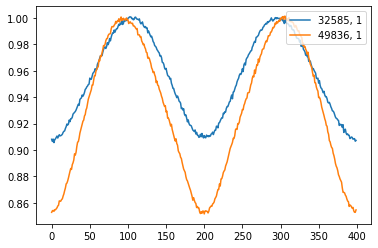

Classification report: 
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     10035
           1       0.99      0.99      0.99      9965

    accuracy                           0.99     20000
   macro avg       0.99      0.99      0.99     20000
weighted avg       0.99      0.99      0.99     20000



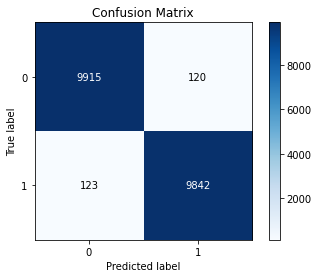

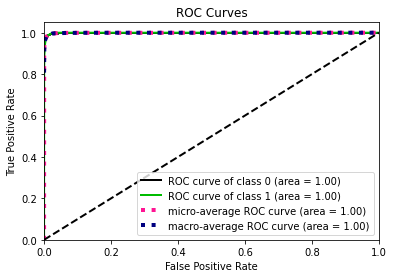

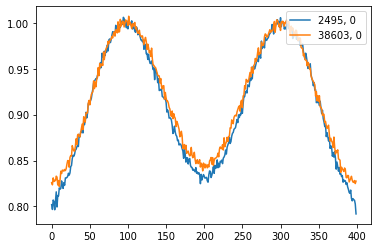

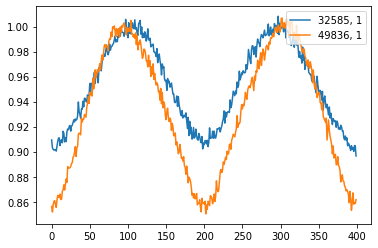

Classification report: 
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     10035
           1       0.99      0.98      0.99      9965

    accuracy                           0.99     20000
   macro avg       0.99      0.99      0.99     20000
weighted avg       0.99      0.99      0.99     20000



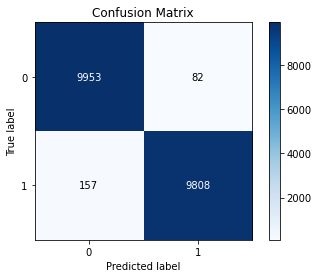

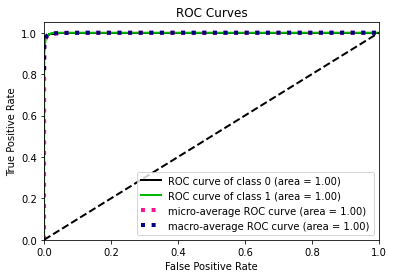

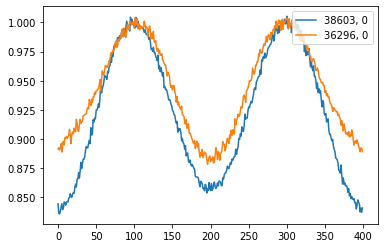

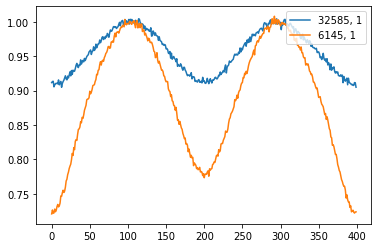

Classification report: 
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     10035
           1       0.99      0.98      0.99      9965

    accuracy                           0.99     20000
   macro avg       0.99      0.99      0.99     20000
weighted avg       0.99      0.99      0.99     20000



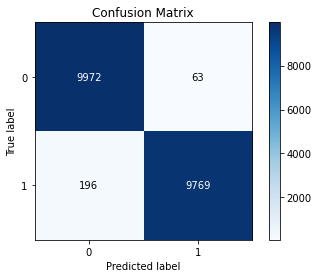

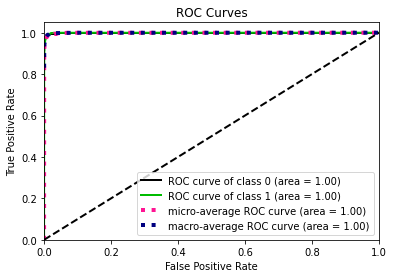

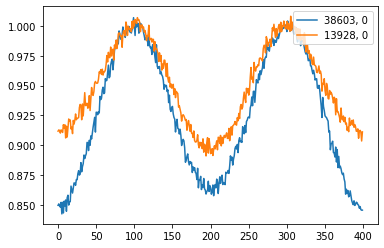

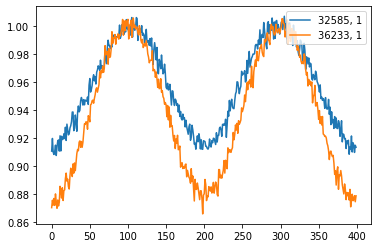

Classification report: 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     10035
           1       1.00      0.98      0.99      9965

    accuracy                           0.99     20000
   macro avg       0.99      0.99      0.99     20000
weighted avg       0.99      0.99      0.99     20000



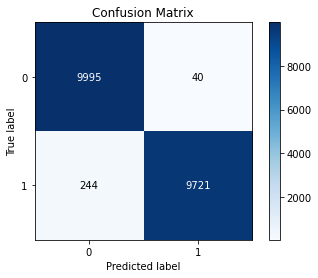

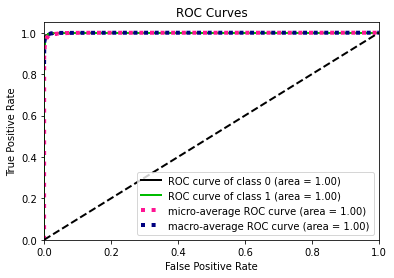

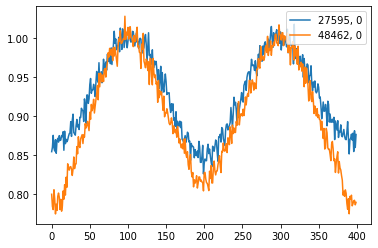

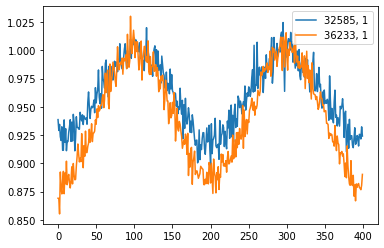

In [23]:
processed_test_data=[
 X_test_with_arrays_noise[0][0],
 X_test_with_arrays_noise[1][0],
 X_test_with_arrays_noise[2][0],
 X_test_with_arrays_noise[3][0],
 X_test_with_arrays_noise[4][0]]

processed_test_data = np.array(processed_test_data)

print(y_test.shape)
print(processed_test_data.shape)

for UBVRI in processed_test_data:
    evaluate_all('model_experiment_2_50000.hdf5', UBVRI, y_test)

# Model 3 evaluation

(100000,)
(100000, 400, 1)
Classification report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     50175
           1       1.00      1.00      1.00     49825

    accuracy                           1.00    100000
   macro avg       1.00      1.00      1.00    100000
weighted avg       1.00      1.00      1.00    100000



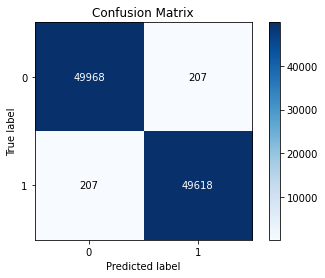

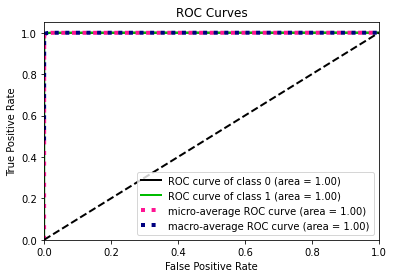

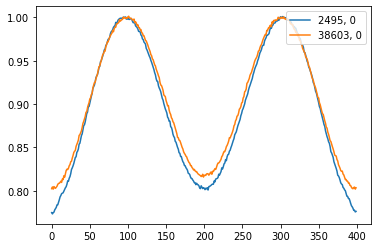

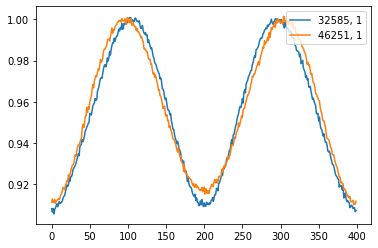

In [24]:
processed_test_data= np.concatenate((
 X_test_with_arrays_noise[0][0],
 X_test_with_arrays_noise[1][0],
 X_test_with_arrays_noise[2][0],
 X_test_with_arrays_noise[3][0],
 X_test_with_arrays_noise[4][0]))

y_test_mixed = pd.concat([y_test,
                            y_test, 
                            y_test, 
                            y_test,
                            y_test]) 
print(y_test_mixed.shape)
print(processed_test_data.shape)

evaluate_all('model_experiment_3_50000.hdf5', processed_test_data, y_test_mixed)